In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

In [4]:
def integrand_function(x):
    return x**2 + torch.sin(6 * x)

def integral_function(x):
    return x**3/3 - torch.cos(6 * x)/6.

In [5]:
x = torch.linspace(0, 1, 100)
g = integrand_function(x)
I = integral_function(x)

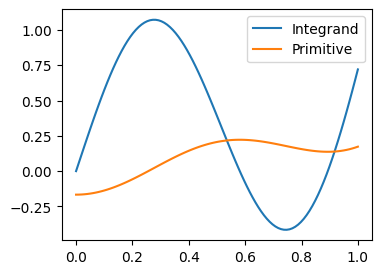

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(x, g, label="Integrand")
plt.plot(x, I, label="Primitive")
plt.legend()
plt.show()

[Qibo 0.2.17|INFO|2025-03-14 16:22:58]: Using qiboml (pytorch) backend on cpu
[Qibo 0.2.17|ERROR|2025-03-14 16:22:58]: Given list of parameters has length 16 while the circuit contains 24 parametrized gates.


ValueError: Given list of parameters has length 16 while the circuit contains 24 parametrized gates.

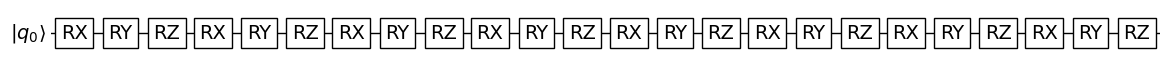

In [39]:
def integrand_function(x):
    return x**2 + torch.sin(6 * x)

def integral_function(x):
    return x**3/3 - torch.cos(6 * x)/6.

x_train = torch.linspace(0, 1, 50, dtype=torch.float64).unsqueeze(1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = integrand_function(x_train)

set_backend("qiboml", platform="pytorch")

nqubits = 1

# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
)

# The whole model
model = QuantumModel(
    circuit_structure=[
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ,
        trainable_circuit(entanglement=True),
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ, 
        trainable_circuit(entanglement=True),
        encoding_circ,
        trainable_circuit(entanglement=True),
    ],
    decoding=decoding_circ,
)

model.draw()

optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.99, 0.999))
criterion = nn.MSELoss()


for epoch in range(100):
    optimizer.zero_grad()

    # Forward pass with gradient tracking
    y_pred = torch.stack([model(x) for x in x_train]).squeeze(-1)

    # Compute derivative of the output w.r.t input
    grad_outputs = torch.ones_like(y_pred)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_train,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Loss comparing derivative prediction (dydx) against integrand function y_train
    loss = criterion(dydx, y_train)

    # Backpropagate
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

In [36]:
predictions = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

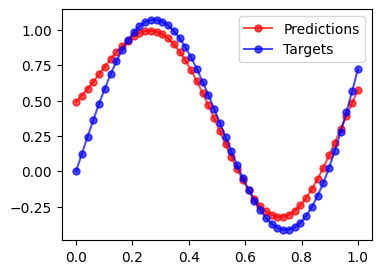

In [37]:
plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train, 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x_train, 
    y_train,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()